<center>
<h1>STAT 654: Statistical Computing with R and Python</h1>
<h2>Simple Regression in Python</h2>
<strong>
Daniel Drennan<br>
Dr. Sharmistha Guha<br><br>
Department of Statistics<br>
Texas A&M University<br>
College Station, TX, USA<br><br>
Spring 2022<br>
</strong>
</center>

**Note**: All Python code can be downloaded from <https://github.com/danjdrennan/stat654-python> or Canvas.

**References**:

1. James, G., Witten, D., Hastie, T. and Tibshirani, R., 2013.
An introduction to statistical learning (Vol. 112, p. 18).
New York: springer.

2. Warmenhoven, Jordi. <https://github.com/JWarmenhoven/ISLR-python>

3. Heart data from 
<https://trevorhastie.github.io/ISLR/Heart.csv> or <https://www.kaggle.com/johnsmith88/heart-disease-dataset>

4. [Scikit-learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)

5.* Breiman, L., 2001. 
Statistical modeling: The two cultures (with comments and a rejoinder by the author).
Statistical science, 16(3), pp.199-231.

*Breiman's paper highlighted the importance of prediction and machine learning models for statisticians.
It gave a larger voice to that community moving into the twenty-first century, and unified some ideas between
computer scientists and statisticians.
If you have time to read the paper, I highly recommend visiting the reference some time.

In [1]:
# Core Python utilities for working with paths
import os, sys

# We're ignoring a FutureWarning from Pandas about a scheduled change to their row indexing method.
# Turn off the warnings filter to see the message, but its scope should be contained to users working
# with time series data wherein the row index is a datetime object.
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Scipy stack for data analysis
import numpy as np
import pandas as pd
import scipy as sp
import scipy.stats

# Plotting / Data Viz
import matplotlib.pyplot as plt
import seaborn as sns

# Libraries for 
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

In [2]:
# This cell will be difficult to get working if you do not pull the repository from GitHub
# because it uses a relative import of the plot function from ../src/plotting.
# This plot function wraps matplotlib.pyplot.plot to remove some boilerplate code for making
# legends, plot labels, a background grid, etc.

# If you're downloading the files locally and this does not work, there are two alternatives:
# (1) replace the contents of this cell with the plot function from plotting.py
# (2) copy plotting.py into the folder with this code and remove line 14 from this cell

# The point here is to demonstrate how to develop more portable, repeatable code than a notebook
# allows for. In a professional organization, this is a useful skill to have developed, and this
# example demonstrates one way to do it. Ideally, though, you'd write a Python package for your team
# and put it into some kind of source control (like GitHub).
sys.path.insert(0, os.path.abspath("../src"))
from plotting import plot

# Simple Regression Models

This notebook highlights several approaches to fitting a simple regression model in Python.
For expendiency, we'll start by picking a dataset and fitting the models.
Once that's done, we will recap the tools used to discuss their pros and cons.

Consider paired data $(x_1, y_1), (x_2, y_2), \ldots, (x_n, y_n)$,
where the $y_i$'s are a response and the $x_i$'s are covariates (explanatory/control variables).
We want to fit a simple regression mode where
$$
    y_i = \beta_0 + \beta_1 x_i + \epsilon_i,\quad \epsilon_i \overset{iid}{\sim} N(0, \sigma^2).
$$
The mean function $\beta_0 + \beta_1 x_i$ is considered fully deterministic (constant in expectations).
As a result, the mean response is $E(y_i) = \beta_0 + \beta_1 x_i + E(\epsilon_i) = \beta_0 + \beta_1 x_i$.

A matrix notation is more useful to us when estimating the models, so we will equivalently write the model
as $\mathbf{y} = \mathbf{X}\beta + \epsilon,\ \epsilon \sim N(\mathbf{0}, \sigma^2\mathbf{I}_{n\times n})$.
Here, $\mathbf{y} = (y_1, \ldots, y_n)$ is a column vector,
$$
    \mathbf{X} =
    \begin{bmatrix}
        1 & x_1 \\
        1 & x_2 \\
        \vdots & \vdots \\
        1 & x_n
    \end{bmatrix}
$$
is a design matrix, $\beta = (\beta_0, \beta_1)$ is a parameter vector, 
and $\epsilon = (\epsilon_1, \ldots, \epsilon_n)$ is a random error vector.

There are about four easy ways to fit such a model in Python. We can use subroutines from numpy and scipy (equivalent),
using sci-kit learn (sklearn), or using statsmodels.
If we only care about approximation or prediction, the first three are all suitable.
If inference is important, as it often is, then statsmodels will provide the best result.
Even still, we'll demonstrate how to estimate the regression model in each case.

## Sample Dataset

We're going to look at a subset of the Heart dataset from ISLR [source1](https://trevorhastie.github.io/ISLR/Heart.csv),
[source2](https://www.kaggle.com/johnsmith88/heart-disease-dataset).
The dataset represents a population of patients reporting chest pain at hospitals in four geographies
(see data for more details).
This data contains far more attributes than we'll consider, in which context it will make more sense to apply an ensemble
method such as random forests or support vector machines.
For now we will consider the relationship between a person's age and cholestoral level.

The files can be downloaded from a terminal using one of the following commands

```bash
# Windows Powershell
curl -o data/heart.csv https://trevorhastie.io/ISLR/Heart.csv

# Linux bash terminal
wget https://trevorhastie.io/ISLR/Heart.csv
```

In [3]:
# Data source: ISLR Heart Data, available from
# https://trevorhastie.github.io/ISLR/Heart.csv
# Described in Chapter 8 of ISLR
# Data also described at https://www.kaggle.com/johnsmith88/heart-disease-dataset
df = pd.read_csv('../data/islr/heart.csv', usecols=["Age", "Chol"])
df.head()

,Age,Chol
0,63,233
1,67,286
2,67,229
3,37,250
4,41,204


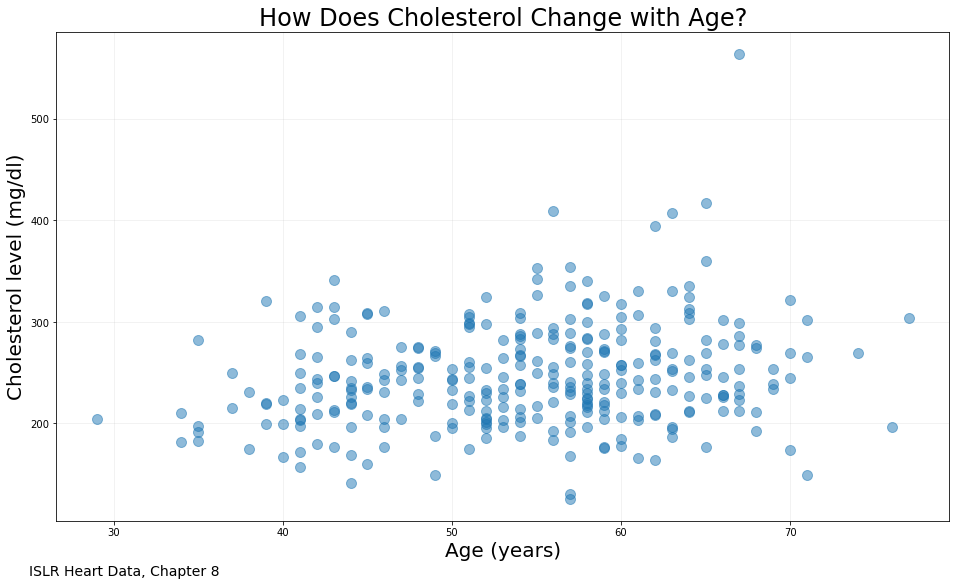

In [4]:
labels = {
    "title": "How Does Cholesterol Change with Age?",
    "x_label": "Age (years)",
    "y_label": "Cholesterol level (mg/dl)"
}
plot(df.Age, df.Chol, labels = labels, marker="o", ms=10, alpha=0.5, linestyle="none")
plt.text(25, 50, "ISLR Heart Data, Chapter 8", fontsize=14)
plt.show()

## Fitting an OLS model in Numpy and Scipy

Estimating an OLS model in Numpy is most appealing for its convenience.
But this will look more like approximating the model using pure MATLAB/linear algebra than statistics.
To fit a least squares model in Python, cast the model into its matrix form.
The result follows by calling to `np.linalg.lstsq`, which has this return documentation

```python
x : {(N,), (N, K)} ndarray
    Least-squares solution. If `b` is two-dimensional,
    the solutions are in the `K` columns of `x`.

residuals : {(1,), (K,), (0,)} ndarray
    Sums of squared residuals: Squared Euclidean 2-norm for each column in
    ``b - a @ x``.
    If the rank of `a` is < N or M <= N, this is an empty array.
    If `b` is 1-dimensional, this is a (1,) shape array.
    Otherwise the shape is (K,).

rank : int
    Rank of matrix `a`.

s : (min(M, N),) ndarray
    Singular values of `a`.
```

In [5]:
# There are a few ways to make the matrix we need.
# The np.r_ and np.c_ functions are good for extending rows and columns of the data lazily.
X = np.c_[np.ones(df.shape[0]), df.Age.values]

# We'll bring the response variable out into its own vector for this portion because it
# requires reshaping the data as a numpy vector with dimensions (n, 1).
# Numpy by default gives dimensionless vectors. So we must reshape the data even though it
# makes no effective changes to the data, only its computer structure.
y = df.Chol.values.reshape(-1, 1)

# Now solve the OLS problem.
# Returns 
numpy_ols = np.linalg.lstsq(X, y)

# These format strings are extremely helpful!
print("Numpy OLS Coefficient estimates: Intercept b0 = {:.4f}, Slope b1 = {:.4f}".format(*numpy_ols[0].reshape(-1)))
print("Numpy OLS SSE = {:,.4f}".format(numpy_ols[1][0]))
print("Numpy OLS model rank = {:.0f}".format(numpy_ols[2]))
print("Numpy OLS Singular values: {:.4f}, {:.4f}".format(*numpy_ols[-1]))

Numpy OLS Coefficient estimates: Intercept b0 = 181.5325, Slope b1 = 1.1969
Numpy OLS SSE = 774,268.4267
Numpy OLS model rank = 2
Numpy OLS Singular values: 960.6966, 2.8461


As far as I know, Scipy's only support for OLS modeling is made available by importing Numpy's linalg library.
So the results are going to be exactly the same as Numpy's.
But in any case, for completeness, a version of that modeling is shown below.

One change you'll notice from the Numpy function and Scipy is that we don't have to pass the `rcond` argument.
The `rcond` argument in Numpy suppresses a warning about some future change to the library.
Scipy reconciles that behavior.
But the main point is that comparing the two outputs yields consistent results (good thing).

In [6]:
from scipy.linalg import lstsq

scipy_ols = lstsq(X, y)

print("Scipy OLS Coefficient estimates: Intercept b0 = {:.4f}, Slope b1 = {:.4f}".format(*scipy_ols[0].reshape(-1)))
print("Scipy OLS SSE = {:,.4f}".format(scipy_ols[1][0]))
print("Scipy OLS model rank = {:.0f}".format(scipy_ols[2]))
print("Numpy OLS Singular values: {:.4f}, {:.4f}".format(*scipy_ols[-1]))

Scipy OLS Coefficient estimates: Intercept b0 = 181.5325, Slope b1 = 1.1969
Scipy OLS SSE = 774,268.4267
Scipy OLS model rank = 2
Numpy OLS Singular values: 960.6966, 2.8461


## OLS through scikit-learn

Scikit-learn will yield a different result from Numpy and Scipy.
The input arguments are similar to Numpy/Scipy---the inputs must be design matrices with specified dimensions.
For simple regression, we make the import (see above) `from sklearn.linear_model import LinearRegression`.
This is the most lightweight import we can make, although there are many more in the library to make.
It has several helpful functions for preprocessing/splitting data.

This is a machine-learning focused library, so the inference tools will not be as satisfying as what you obtain from R.
But an advantage to fitting your model in this library is that many of the learners (models) come equipped with routines
to handle sparse matrices or to do penalization.
They also come with a handy predict method which we can use to make out-of-sample predictions
(this is a machine learning library, after all!).
As far as model comparison goes, this library is incredibly efficient to work with.

**One important note**: I've used this library for a few years, and each time I use it I forget that it has a boolean
parameter that seems to be coded backwards in source; at least that's the case for some Windows users!
If you specify `fit_intercept=True` in the call to LinearRegression, you might fit a model with no intercept!
Check this behavior before using the model in production.

In [7]:
sklearn_ols = LinearRegression(fit_intercept=False).fit(X, y)

print("sklearn coefficient estimates: intercept b0 = {:.4f}, slope b1 = {:.4f}".format(*sklearn_ols.coef_[0]))
print("sklearn R^2 estimate {:.4f}".format(sklearn_ols.score(X, y)))
print("sklearn SSE = {:,.4f}".format(sklearn_ols._residues[0]))

sklearn coefficient estimates: intercept b0 = 181.5325, slope b1 = 1.1969
sklearn R^2 estimate 0.0437
sklearn SSE = 774,268.4267


In [8]:
# Take 2: This is the better way to fit a model in sklearn.
# Previously we punched a design matrix through the model, but we don't need to do that.
# Instead, we can pass only the slopes through the model and tell it to fit an intercept term.
# So let's look at how to do that now.

# First, let's truncate the design matrix to include only the slope.
# We need to reshape the data so it doesn't reduce it to a lower form of vector
X = X[:, 1].reshape(-1, 1)

sklearn_ols = LinearRegression().fit(X, y)

b0, b1 = sklearn_ols.intercept_[0], sklearn_ols.coef_[0][0]

print("sklearn coefficient estimates: intercept b0 = {:.4f}, slope b1 = {:.4f}".format(b0, b1))
print("sklearn R^2 estimate {:.4f}".format(sklearn_ols.score(X, y)))
print("sklearn SSE = {:,.4f}".format(sklearn_ols._residues[0]))

sklearn coefficient estimates: intercept b0 = 181.5325, slope b1 = 1.1969
sklearn R^2 estimate 0.0437
sklearn SSE = 774,268.4267


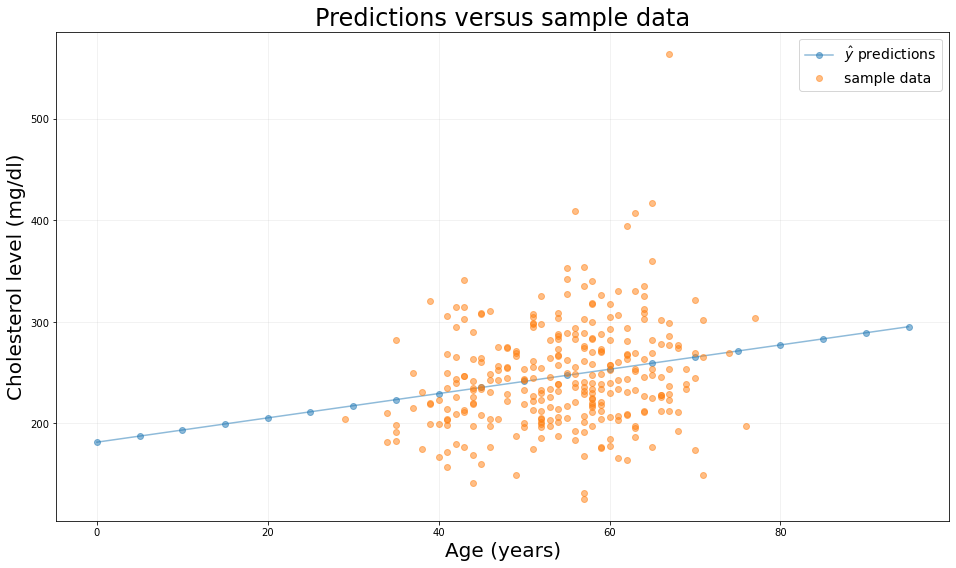

In [9]:
# Now we can see how prediction works
xnew = np.arange(0, 100, 5).reshape(-1, 1)

# Now we get predictions
yhat = sklearn_ols.predict(xnew)

prediction_labels = labels
prediction_labels['title'] = 'Predictions versus sample data'

plot(xnew, yhat, marker="o", labels=prediction_labels, alpha=0.5, label="$\hat{y}$ predictions")
plt.plot(X.reshape(-1), y.reshape(-1), "o", alpha=0.5, label="sample data")
plt.legend(fontsize=14)
plt.show()

## Simple regression models in statsmodels

Now we come to the statsmodels solution, which is the most similar to what one would expect coming from R.
This is the library to use if you're concerned with inference and do not want to write your own routines.
Using this library, we'll get model summaries that can be exported to an external environment to prepare reports
or interpret models.
There's no flag for significant intercept coefficients, but the output provides more information than a typical R model
would.
We also get R-like formulas, although they're not as flexible as the formulas in R.

In [10]:
formula = "Chol ~ Age"
lm = sm.OLS.from_formula(formula, data = df).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Chol   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     13.74
Date:                Wed, 09 Feb 2022   Prob (F-statistic):           0.000250
Time:                        20:20:34   Log-Likelihood:                -1618.6
No. Observations:                 303   AIC:                             3241.
Df Residuals:                     301   BIC:                             3249.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    181.5325     17.818     10.188      0.000     146.470     216.595
Age            1.1969      0.323      3.707      0.000       0.562       1.832
==============================================================================
Omnibus:                       73.471   Durbin-Watson:                   2.075
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              248.422
Skew:                           1.025   Prob(JB):                     1.14e-54
Kurtosis:                       6.934   Cond. No.                         338.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

[]

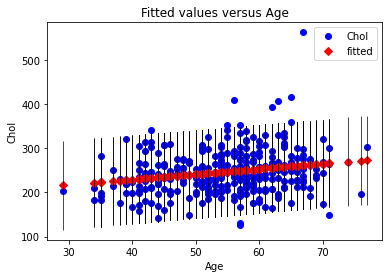

In [11]:
# Not as comprehensive as R's diagnostic plots, but still useful
sm.graphics.plot_fit(lm, "Age")
plt.plot()

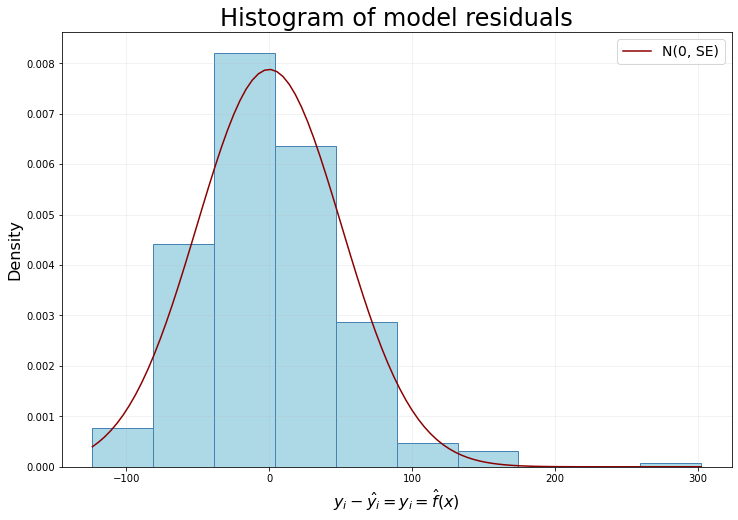

In [12]:
x = np.linspace(lm.resid.min(), lm.resid.max(), 100)
n = sp.stats.norm(0, lm.resid.std()).pdf

plt.figure(figsize=(12,8))
plt.title("Histogram of model residuals", fontsize=24)
plt.xlabel("$y_i - \hat{y_i} = y_i = \hat{f}(x)$", fontsize=16)
plt.ylabel("Density", fontsize=16)
plt.hist(lm.resid, density=True, color="lightblue", edgecolor="steelblue")
plt.plot(x, n(x), color="darkred", label="N(0, SE)")
plt.legend(fontsize=14)
plt.grid(alpha=0.2)
plt.show()

In [13]:
def predict(x, beta):
    """Predict values for a simple regression using a coefficient vector from an OLS fit"""
    return beta[0] + beta[1] * x

x = np.array([df.Age.min(), df.Age.max()])
yhat = predict(x, numpy_ols[0])

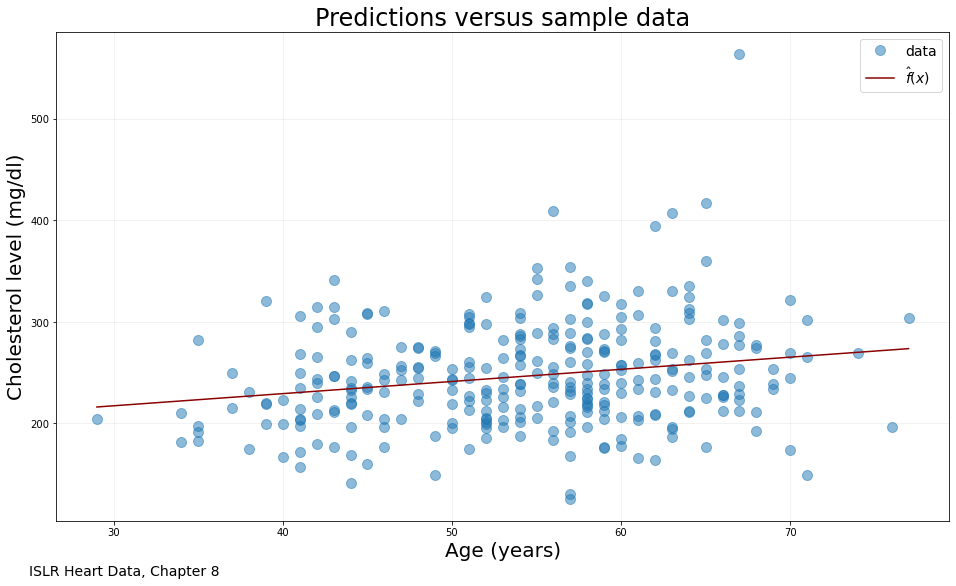

In [14]:
plot(df.Age, df.Chol, labels = labels, marker="o", ms=10, alpha=0.5, linestyle="none", label="data")
plt.plot(x, yhat, color="darkred", label="$\hat{f}(x)$")
plt.text(25, 50, "ISLR Heart Data, Chapter 8", fontsize=14)
plt.legend(fontsize=14)
plt.show()

## Summary

We saw how to fit an OLS model using numpy, scipy, scikit-learn, and statsmodels.
It will turn out that each method we used can be extended to arbitrarily many predictors,
although the latter two models are much easier to work with in such cases.

Each library gave a different set of outputs after learning (estimating, fitting) the model.
In particular, some outputs may be more useful depending on the intended model use.
As statisticians, uncertainty quantification is often a major part of our contribution to collaborators.
As such, a library that fails to produce inferential tools or standard errors is one we should build around and expand.
But aside from different outputs for each model, what benefit do we gain from learning the same model with
different libraries? Perhaps the greatest benefit to fitting several equivalent models in software is to
ensure library consistency. The routines for these models are all similar, but they're versioned differently.
So if you can fit the same model three or four different ways, you'll have more confidence about the correctness of
the results.

What were the pros and cons of the libraries we looked at?

**Numpy**:

| Pros | Cons |
| ---- | ---- |
| Always in environment | Not easy to use for prediction or inference |
| Very similar to scipy | Requires augmenting data in some way |
| Very fast | Results are difficult to extract and work with |

**Scipy**:

| Pros | Cons |
| ---- | ---- |
| Easier than numpy | Requires augmenting data and importing the library |
| Very fast | Results are difficult to work with |

**sklearn**:

| Pros | Cons |
| ---- | ---- |
| Easy model comparison | `fit_parameter` code |
| Easy model predictions | Few outputs to work with |

**statsmodels**:

| Pros | Cons |
| ---- | ---- |
| Awesome inference | Not as useful for prediction, but similar to R outputs |

Note: for the prediction-based libraries, we can always bootstrap standard errors.
Bootstrapping makes no distributional assumptions, which may be appealing if you're skeptical of the
normal distribution error assumption used in OLS.